# Cucumber or Zucchini

### Task
Use `fastai.vision` to classify two very similar vegetables, cucumber and zucchini (or courgette).

The `fastai` library is well documented and the API makes it incredibly easy to create deep learning models.

Steps:
1. Use DuckDuckGo to find images of cucumbers
2. Use DuckDuckGo to find images of zucchinis
3. Fine-tune a pretrained neural network architecture to classify each vegetable
4. Test the model

### A GPU is required to process the images efficiently

### Images of cucumbers and zucchinis

Upgrade/install the latest versions of the libraries.

In [1]:
!pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
ray 2.0.0 requires click<=8.0.4,>=7.0, but you have click 8.1.3 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2022.2.0 which is incompatible.


In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import L

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Testing the function `search_images`

In [5]:
urls = search_images('cucumber photos', max_images=1)
urls[0]

Searching for 'cucumber photos'


'http://eatwellenjoylife.com/wp-content/uploads/2014/08/cucumber.jpg'

Download and view URL

In [6]:
from fastdownload import download_url
dest = 'cucumber.jpg'
download_url(urls[0], dest, show_progress=True)

Path('cucumber.jpg')

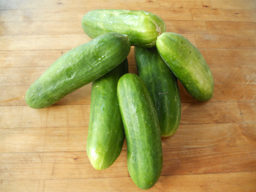

In [8]:
from fastai.vision.all import *
image = Image.open(dest)
image.to_thumb(256,256)

That looks like a zucchini to me...

Download and view a zucchini image

Searching for 'zuchinni photos'


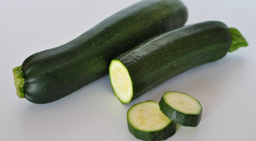

In [10]:
download_url(search_images('zuchinni photos', max_images=1)[0], 'zucchini.jpg')
Image.open('zucchini.jpg').to_thumb(256,256)

That's definately a zucchini.

Download cucumber and zucchini images. Include images of them cut to increase dataset.

In [11]:
searches = 'zucchini', 'cucumber'
path = Path('cucumber_or_not')

In [12]:
from time import sleep
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10) # using kaggle's GPUs and avoiding over loading the servers
    download_images(dest, urls=search_images(f'{o} cut photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} peeled photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'zucchini photo'
Searching for 'zucchini cut photo'
Searching for 'zucchini peeled photo'
Searching for 'cucumber photo'
Searching for 'cucumber cut photo'
Searching for 'cucumber peeled photo'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


### Train the model

Check if some images did not download properly

In [14]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

Use `DataLoaders` to train the model
- `blocks` - model inputs are images, use `ImageBlock`, and outputs are categories, use `CategoryBlock`
- `get_items` - find all inputs to the model
- `splitter` - split data into training and validation sets
- `get_y` - use the labels as the images to put them into separate folders
- `item_tfms` - transform the image by resizing it to 192x192 pixels by "squishing", instead of cropping it

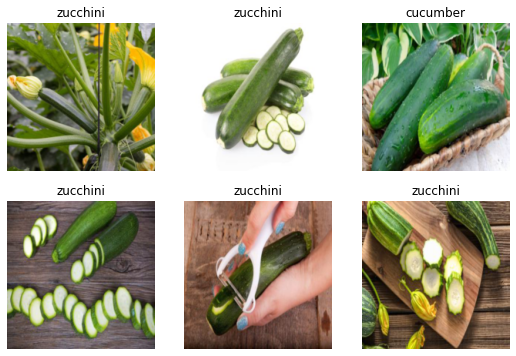

In [15]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
    ).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

The fastest computer vision model is `resnet18`

Call `fine_tune` instead of `fit`

In [17]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.084692,1.060945,0.382353,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.715573,0.759894,0.352941,00:02
1,0.628363,0.627225,0.352941,00:01
2,0.501370,0.590940,0.323529,00:02
3,0.382758,0.585824,0.264706,00:01
4,0.305608,0.591346,0.264706,00:01
5,0.251658,0.572546,0.235294,00:01
6,0.212926,0.583081,0.264706,00:01
7,0.181685,0.579475,0.294118,00:01
8,0.156525,0.570511,0.294118,00:02
9,0.136634,0.589994,0.294118,00:01


Model is not performing great - high validation loss and error rate. Perhaps another architecture, istead of `resnet18` is required. Or cucumbers and zuchinnis are inseparable.

### Test the model

In [25]:
is_cucumber,_,probs = learn.predict(PILImage.create('cucumber.jpg'))
print(f"This is a: {is_cucumber}.")
print(f"Probability it's a cucumber: {probs[0]:.5f}")

This is a: cucumber.
Probability it's a cucumber: 0.99837


### Test with `resnet152`

In [26]:
learn = vision_learner(dls, resnet152, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.126375,1.059538,0.294118,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.396578,0.288583,0.147059,00:04
1,0.264216,0.280403,0.117647,00:03
2,0.223964,0.351347,0.117647,00:03
3,0.179276,0.557430,0.147059,00:03
4,0.152875,0.715486,0.235294,00:03
5,0.124419,0.693435,0.264706,00:03
6,0.105874,0.570304,0.264706,00:03
7,0.091964,0.534988,0.147059,00:03
8,0.079886,0.515645,0.147059,00:03
9,0.069166,0.519787,0.176471,00:03


With 10 epochs, the model is severely overfitting. The training loss continues to decrease but the validation loss is increasing. Perhaps and different architecture, or a different number of epochs.